# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [30]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sns


In [32]:
workdir='/ipynb_files/CHEM96_06/Project_1/'
datadir='/ipynb_files/CHEM96_06/Exercise_0/data/'
outdir='/ipynb_files/CHEM96_06/Project_1/outdir'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/ipynb_files/CHEM96_06/Exercise_0/data/butane.pdb
/ipynb_files/CHEM96_06/Exercise_0/data/butane.gaff2.xml


In [5]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.295271861905595 kJ/mol
Potential energy after minimization is 5.295054161663414 kJ/mol


In [6]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,49.39116210158572,342.1816599142087
2000,33.47956960965178,355.8378354698229


In [33]:
os.path.join(workdir, "butane_sim.xtc")

'/ipynb_files/CHEM96_06/Project_1/butane_sim.xtc'

In [8]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,29.4640115085124,323.13085021632577,--
500000,999.9999999901769,33.65382650812714,457.1254264420371,2.86e+03
750000,1499.9999999783536,39.61432104857725,273.6670098614855,2.94e+03
1000000,1999.9999999665301,51.190152294199606,363.48012331847616,3e+03
1250000,2499.9999999547067,43.78022864523871,236.1122352648868,3.01e+03
1500000,2999.9999999428833,25.945977604096495,390.94467684734343,3.03e+03
1750000,3499.99999993106,51.59456739872876,367.6331583085142,3.03e+03
2000000,3999.9999999192364,32.953010017102656,253.69540693578713,3.04e+03
2250000,4499.9999999992715,25.77130068489477,249.86291837877013,3.04e+03
2500000,5000.000000101135,40.32409386509758,265.2316752700345,3.04e+03
2750000,5500.000000202998,37.46649200049896,340.6270516226051,3.04e+03
3000000,6000.000000304862,47.35034127528879,371.13687894916575,3.04e+03
3250000,6500.000000406725,29.809827450433

In [34]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x20fc1f1f290>

In [35]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

In [36]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x20fc4f638d0>

In [37]:
C_sel=top.select("type C")
print(C_sel)
top.atom(10)
for atom in C_sel:
    print(atom,top.atom(atom))

H_sel=top.select("type H")
for atom in H_sel:
    print(atom,top.atom(atom))

[ 0  4  7 10]
0 NBU1-C1
4 NBU1-C2
7 NBU1-C3
10 NBU1-C4
1 NBU1-H11
2 NBU1-H12
3 NBU1-H13
5 NBU1-H21
6 NBU1-H22
8 NBU1-H31
9 NBU1-H32
11 NBU1-H41
12 NBU1-H42
13 NBU1-H43


In [38]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


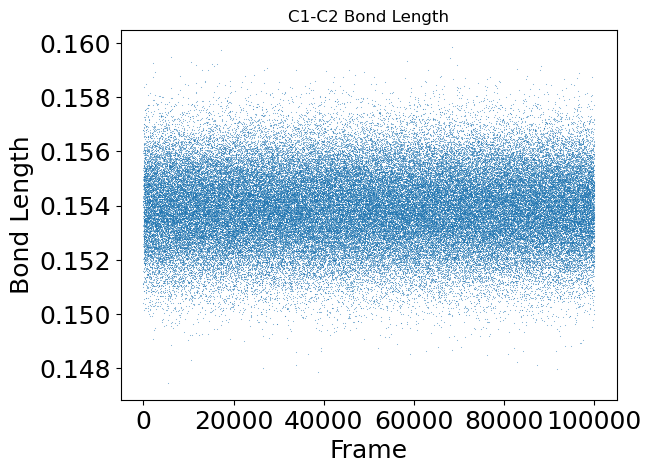

In [39]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C1C2bondlength,linewidth=1)
plt.plot(C1C2bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
#plt.xlim([0,1000])

plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

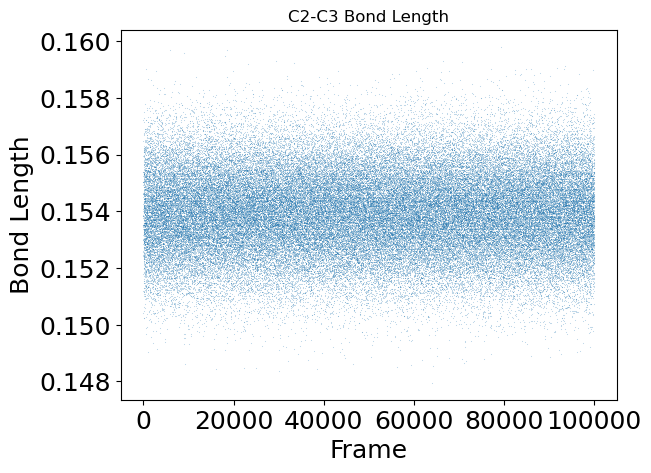

In [40]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C2C3bondlength)
plt.plot(C2C3bondlength,linewidth=0,marker='x',markersize=.05)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

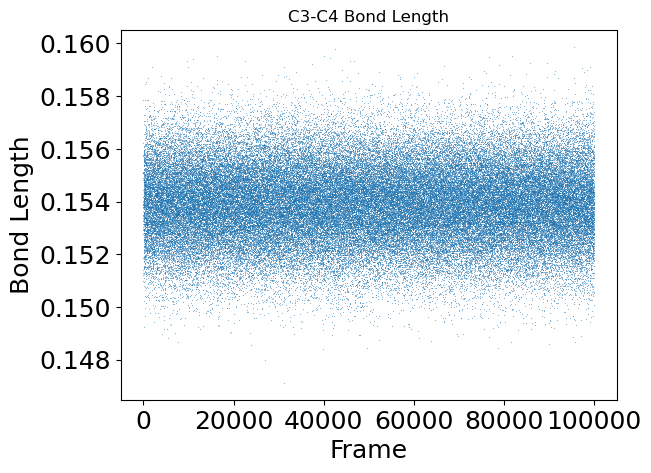

In [41]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
#plt.plot(C3C4bondlength)
plt.plot(C3C4bondlength,linewidth=0,marker='x',markersize=.1)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

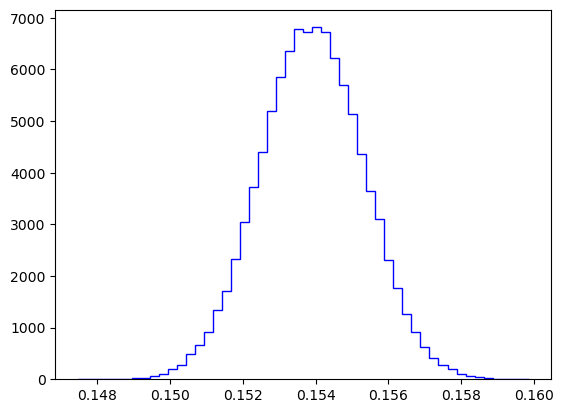

In [42]:
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.show()

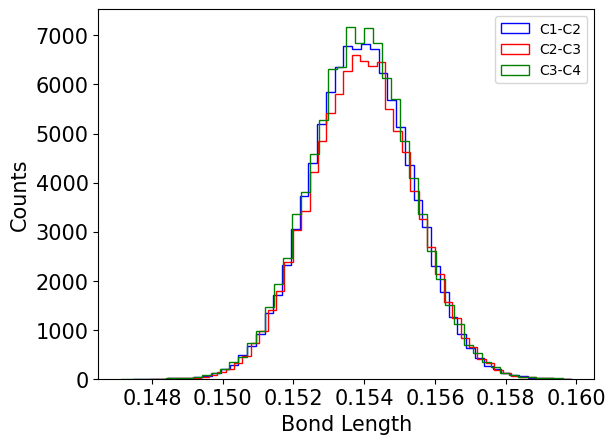

In [43]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

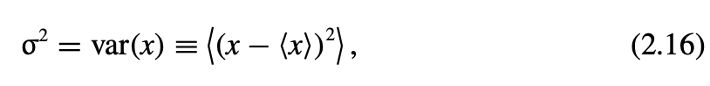

In [44]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [45]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)

print("C1-C2 variance:",C1C2var,"C1-C2 standard deviation:",C1C2std)
print("C2-C3 variance:",C2C3var,"C1-C2 standard deviation:",C2C3std)
print("C3-C4 variance:",C2C3var,"C1-C2 standard deviation:",C3C4std)

C1-C2 variance: 2.0232962e-06 C1-C2 standard deviation: 0.001422426183318153
C2-C3 variance: 2.054492e-06 C1-C2 standard deviation: 0.0014333498928244491
C3-C4 variance: 2.054492e-06 C1-C2 standard deviation: 0.0014319093549975636


In [46]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.1539007 variance: 2.0232962e-06 std-dev: 0.0014224262
C2-C3 average: 0.15394738 variance: 2.054492e-06 std-dev: 0.0014333499
C3-C4 average: 0.15390246 variance: 2.0503644e-06 std-dev: 0.0014319094


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


In [47]:
#Switch to a 1D array 
np.shape(C1C2bondlength[:,0])

(100000,)

Line Parameters: [0.50012809 0.07697334]


C:\Users\Caleb Liu\AppData\Local\Temp\ipykernel_33744\3831820622.py:12: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


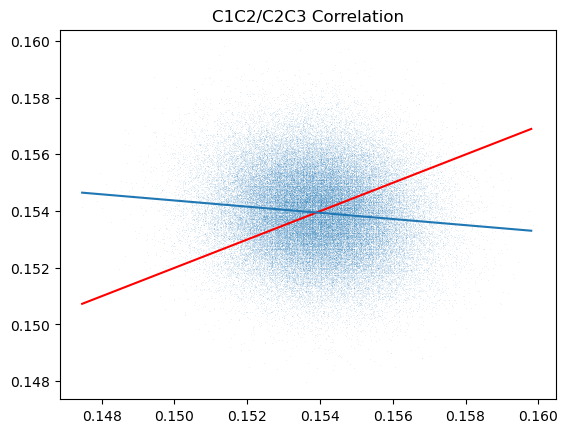

C:\Users\Caleb Liu\AppData\Local\Temp\ipykernel_33744\3831820622.py:27: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


r: -0.10798980923421773
-0.10798980923421769
Line Parameters: [0.49998453 0.07695125]


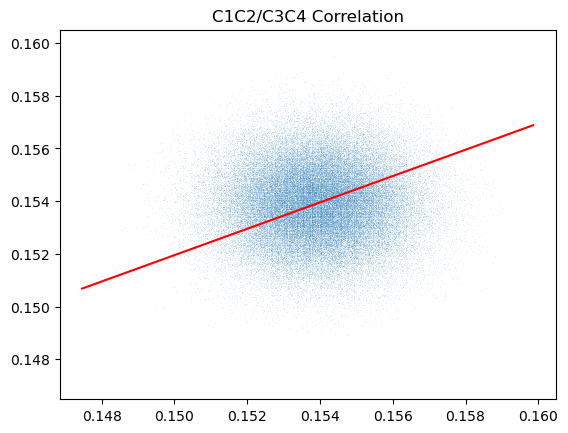

r: 0.0068827144136938715


In [48]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########

results=scipy.stats.linregress(C1C2bondlength[:,0],C2C3bondlength[:,0])
xsp = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
ysp = results[0]*xsp+results[1]

line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.plot(xsp,ysp)
plt.title("C1C2/C2C3 Correlation")
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r:",r[0,1])
print(results[2])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.title("C1C2/C3C4 Correlation")
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r:",r[0,1])

D:\Anaconda\envs\CHEM96_06_24S\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\envs\CHEM96_06_24S\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\envs\CHEM96_06_24S\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\envs\CHEM96_06_24S\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

<Figure size 640x480 with 0 Axes>

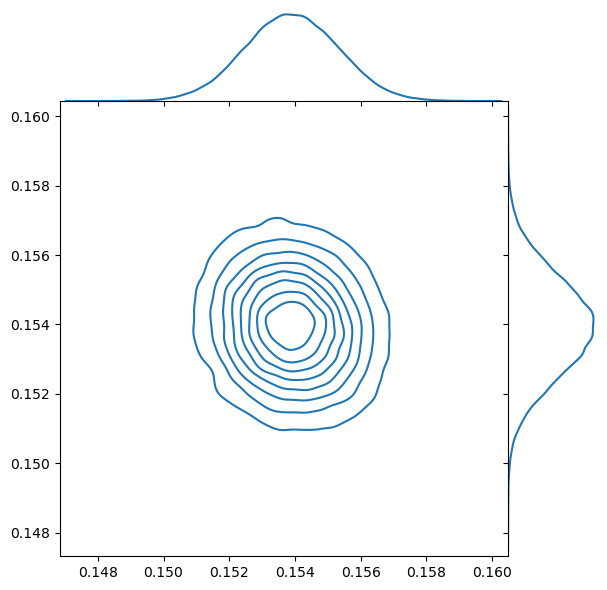

In [49]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='kde',space=0,thresh=0)

D:\Anaconda\envs\CHEM96_06_24S\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\envs\CHEM96_06_24S\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

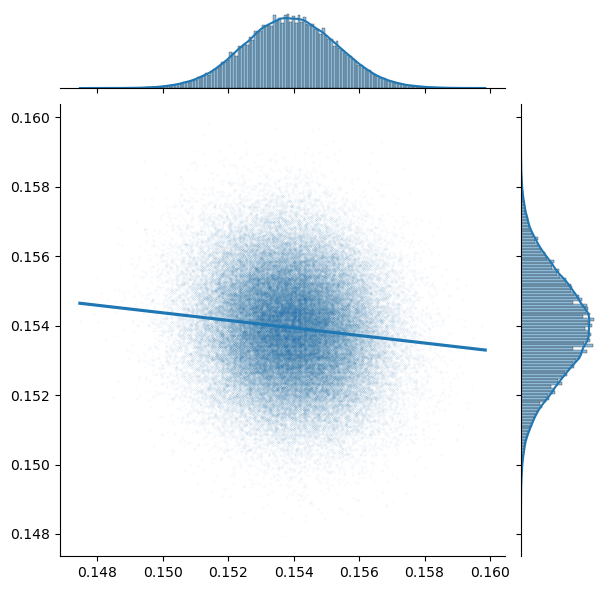

In [22]:
import seaborn as sns
plt.clf()
sns.jointplot(x=C1C2bondlength[:,0],y=C2C3bondlength[:,0],kind='reg',scatter_kws={'s':0.001})

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

HERE IS MY ANSWER:

The correlation coefficient for the C1C2/C2C3 bond is larger in magnitude compared to C1C2/C3C4, and is negative. This suggests a slight negative correlation between the C1C2 and C2C3 bonds, meaning that when C1C2 bond shortens, we can expect (on average) a slight lengthening of the C2C3 bond, but almost no effect for the C3C4 bond. In fact, when only considering the harmonic bond potential in the force field, we expect no correlation whatsoever: the bond wants to stay at a specific length due to a harmonic energy penalty for deviation. 

In short, the correlation arises due to the proximity of the C1C2/C2C3 bonds. Let us consider the shortening of the C1C2 bond as the movement of the C2 atom closer to the C1 atom. When this occurs the C2C3 bond (generally) lengthens, and the harmonic potential between C2 and C3 wants to bring the two atoms together. However, doing so would shift the C3 atom away from its respective hydrogens and the C4 atom and alter the bond angles, increasing the energy of the system. Thus, the other atoms and their associated potentials in the system effectively exert a conservative force on the C3 atom, causing the C2C3 bond to lengthen. This is contrasted with the C3C4 bond, which is not directly affected by the movement of the C2 atom, resulting in little correlation.

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

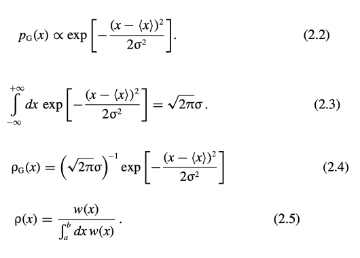
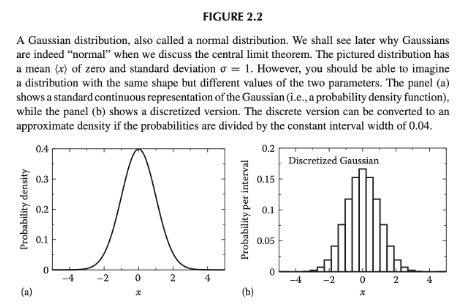

[    1     6    22    80   392  1253  3094  6684 11419 16194 17786 16664
 12504  7859  3818  1520   519   144    37     4] [0.147   0.14765 0.1483  0.14895 0.1496  0.15025 0.1509  0.15155 0.1522
 0.15285 0.1535  0.15415 0.1548  0.15545 0.1561  0.15675 0.1574  0.15805
 0.1587  0.15935 0.16   ]
a: 0.18049519463309355 x_0: 0.15389783991795075 fit_sigma: -0.001438318951578362


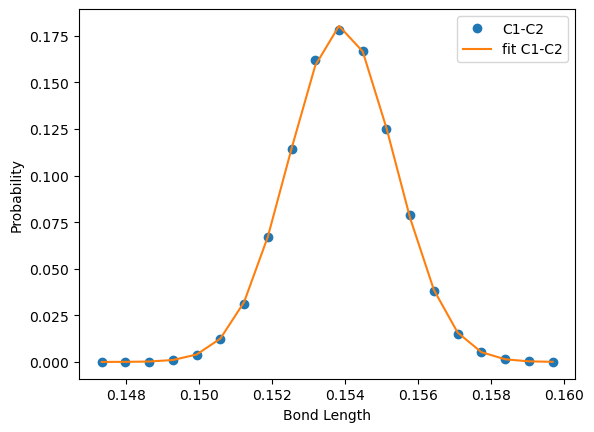

In [50]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength,bins=20,range=[0.147,0.160])
print(counts,edges)
centers = edges[:-1] + np.diff(edges)/2
density=counts/(np.sum(counts))

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####

###Now we define a gaussian function that we'll fit to our probability densities
def gauss(x,a, x0, sigma):
    return(a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss,x,y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x_0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(x,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]


C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers,density,'o',label='C1-C2')
plt.plot(centers,C1C2_fit,'-',label='fit C1-C2')
plt.legend()
plt.xlabel('Bond Length')
plt.ylabel('Probability')
plt.show()

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

[0.20801811 0.15389368 0.00143842]


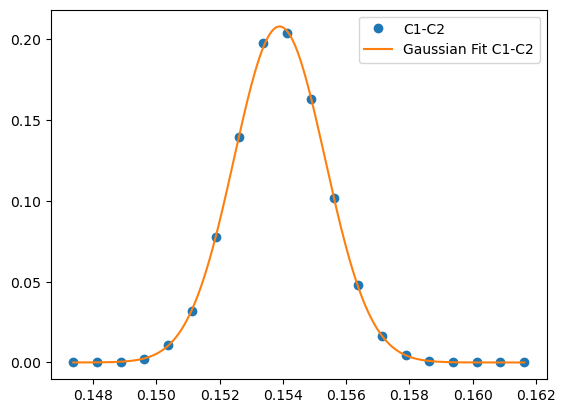

[0.20621455 0.15394003 0.00145115]


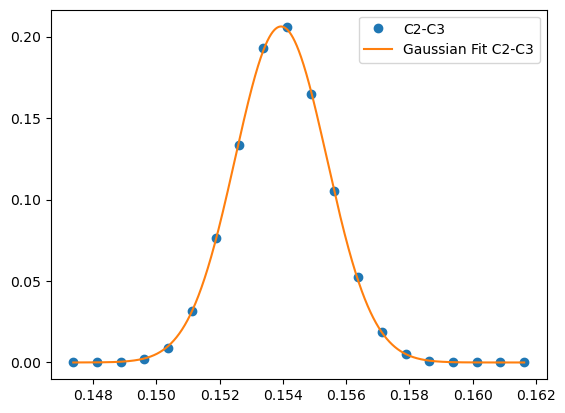

[0.20769924 0.15390656 0.00143737]


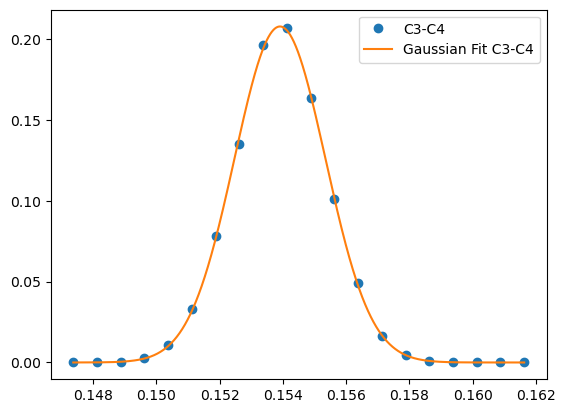

In [139]:
#HERE IS MY ANSWER

#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####
def histogram_bincenters(data, bins, num_range):
    counts, edges = np.histogram(data, bins=bins, range=num_range)
    centers = edges[:-1] + np.diff(edges)/2
    density = counts/np.sum(counts)
    return centers,density 

def fit_gaussian(centers,density):
    param, cov = curve_fit(gauss,centers,density,bounds=(-6,7),maxfev=5000)
    fit_x = np.linspace(centers[0], centers[-1], num=len(centers)*100)
    print(param)
    return fit_x,param[0]*np.exp(-(fit_x-param[1])**2/(2*param[2]**2))

C1C2_centers, C1C2_density = histogram_bincenters(C1C2bondlength, 20, [0.147,0.162])
C1C2_fitx, C1C2_fity = fit_gaussian(C1C2_centers, C1C2_density)
plt.plot(C1C2_centers,C1C2_density,'o',label='C1-C2')
plt.plot(C1C2_fitx,C1C2_fity,'-',label='Gaussian Fit C1-C2')
plt.legend()
plt.show()

C2C3_centers, C2C3_density = histogram_bincenters(C2C3bondlength, 20, [0.147,0.162])
C2C3_fitx, C2C3_fity = fit_gaussian(C2C3_centers, C2C3_density)
plt.plot(C2C3_centers,C2C3_density,'o',label='C2-C3')
plt.plot(C2C3_fitx,C2C3_fity,'-',label='Gaussian Fit C2-C3')
plt.legend()
plt.show()

C3C4_centers, C3C4_density = histogram_bincenters(C3C4bondlength, 20, [0.147,0.162])
C3C4_fitx, C3C4_fity = fit_gaussian(C3C4_centers, C3C4_density)
plt.plot(C3C4_centers,C3C4_density,'o',label='C3-C4')
plt.plot(C3C4_fitx,C3C4_fity,'-',label='Gaussian Fit C3-C4')
plt.legend()
plt.show()

#USE THE FUNCTION TO ITERATE OVER ALL CC BONDS, plot the densities and the fits 

**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

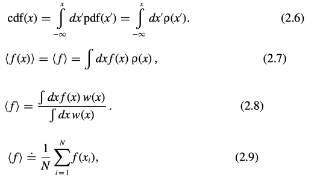

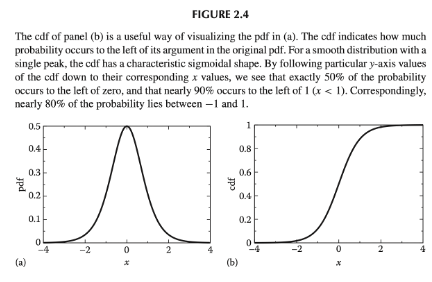

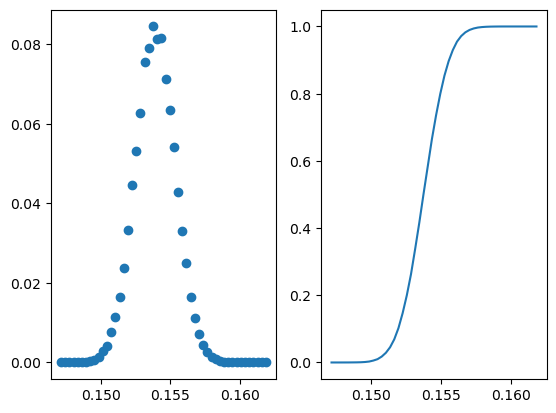

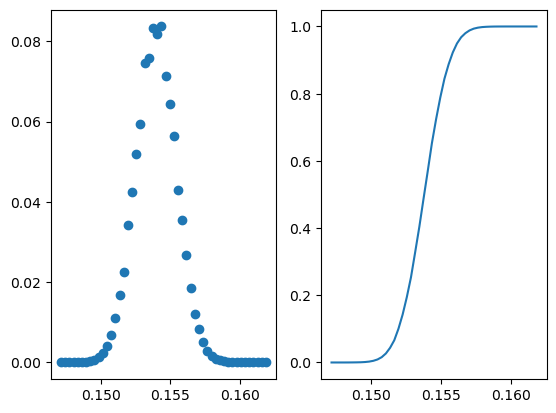

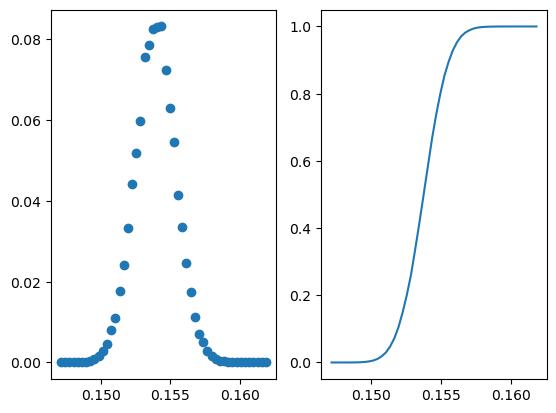

In [52]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####

#TRY THIS FUNCTION:
#https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
#ADD CODE FOR CDFs HERE#

def cdf(density):
    
    #One line only as the densities from the previous histogram are already normalized
    return np.cumsum(density)

fig, axs = plt.subplots(1, 2, sharey=False)
C1C2_centers, C1C2_density = histogram_bincenters(C1C2bondlength, 50,[0.147,0.162])
C1C2_cdf_density = cdf(C1C2_density)
axs[0].plot(C1C2_centers,C1C2_density,'o',label='C1-C2')
axs[1].plot(C1C2_centers,C1C2_cdf_density,'-')

fig, axs = plt.subplots(1, 2, sharey=False)
C2C3_centers, C2C3_density = histogram_bincenters(C2C3bondlength, 50,[0.147,0.162])
C2C3_cdf_density = cdf(C2C3_density)
axs[0].plot(C2C3_centers,C2C3_density,'o',label='C1-C2')
axs[1].plot(C2C3_centers,C2C3_cdf_density,'-')
 
fig, axs = plt.subplots(1, 2, sharey=False)
C3C4_centers, C3C4_density = histogram_bincenters(C3C4bondlength, 50,[0.147,0.162])
C3C4_cdf_density = cdf(C3C4_density)
axs[0].plot(C3C4_centers,C3C4_density,'o',label='C1-C2')
axs[1].plot(C3C4_centers,C3C4_cdf_density,'-')


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle.  Why is the Gaussian fit for a dihedral so poor with a large sample? ***


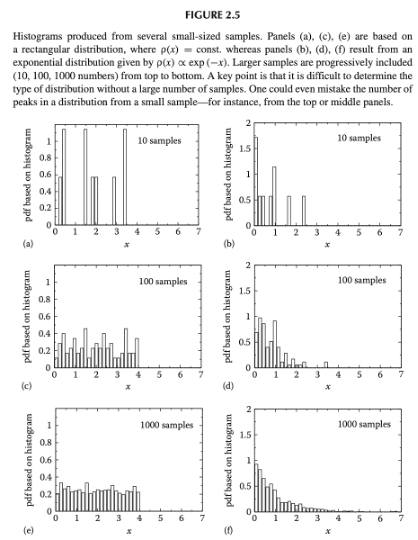

[0.09631519 1.95127848 0.04918961]
[0.07959123 1.97139938 0.06138907]
[0.08384198 1.96739561 0.05708577]
[ 5.18186246e-09  8.10466970e-01 -3.22843161e-01]
[0.16110198 3.02251059 0.10609955]
[ 2.67238527e-08 -2.10098055e-02  2.90945165e-02]


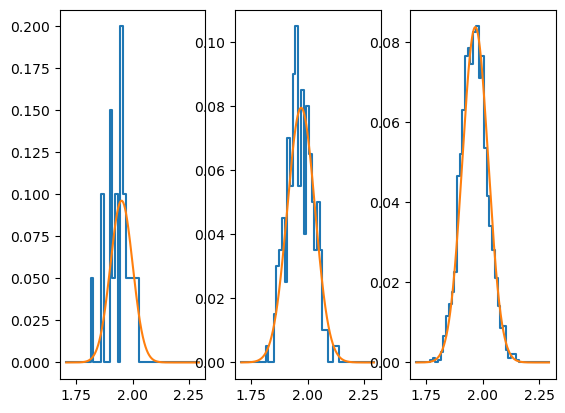

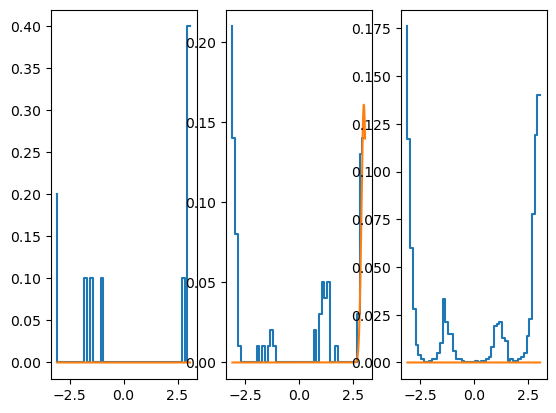

In [125]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE
#Using CCC bond angles between C1C2C3, C2C3C4

C1C2C3_bond_angle = md.compute_angles(traj, [[0,4,7]])
C2C3C4_bond_angle = md.compute_angles(traj, [[4,7,10]])

#Both bond angle arrays are placed side by side
total_angles = np.append(C1C2C3_bond_angle, C2C3C4_bond_angle, axis=1)

fig, axs = plt.subplots(1, 3, sharey=False)
for i in range(1,4):
    random_values=np.random.randint(100000, size=(10**i))
    angles=total_angles[random_values,:]
    angles=np.concatenate(angles)
    angle_centers, angle_density = histogram_bincenters(angles, 50, [1.7,2.3])
    angle_fitx, angle_fity = fit_gaussian(angle_centers, angle_density)
    axs[i-1].step(angle_centers,angle_density)
    axs[i-1].plot(angle_fitx,angle_fity)
    

#This function might be helpful:
#rands=np.random.randint(100000, size=(1000))
#rands
#C1C2bond=C1C2bondlength[:,0]
#C1C2bond[rands]
#plt.hist(C1C2bond[rands],bins=20,histtype='step')
#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?

CCCC_index=[10,7,4,0]
dihedral=md.compute_dihedrals(traj, [CCCC_index])

fig, axs = plt.subplots(1, 3, sharey=False)
for i in range(1,4):
    random_values=np.random.randint(100000, size=(10**i))
    dh=dihedral[random_values,:]
    dh_centers, dh_density = histogram_bincenters(dh, 50, [-np.pi,np.pi])
    dh_fitx, dh_fity = fit_gaussian(dh_centers, dh_density)
    axs[i-1].step(dh_centers,dh_density)
    axs[i-1].plot(dh_fitx,dh_fity)
    
#The dihedrals are fit so poorly by a gaussian because they are not randomly distributed, as multiple energy minima for 
#dihedral potential exist

In [41]:
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

(100000, 2)
[[2.0522265 2.00451  ]
 [1.9579529 1.9343754]
 [1.9944046 1.903865 ]
 ...
 [1.9607215 1.9775729]
 [1.9619436 1.9600526]
 [2.0361748 1.9421183]]


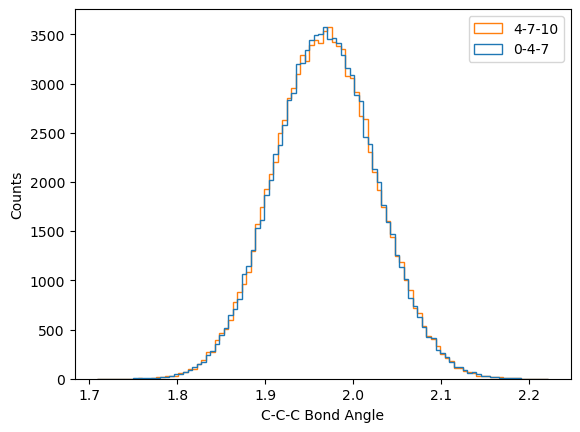

[[ 2.7600465]
 [ 3.0768373]
 [-2.8018565]
 ...
 [-2.8514915]
 [ 3.014763 ]
 [ 2.9626908]]
[[ 158.139  ]
 [ 176.28978]
 [-160.53455]
 ...
 [-163.37842]
 [ 172.7332 ]
 [ 169.74966]]


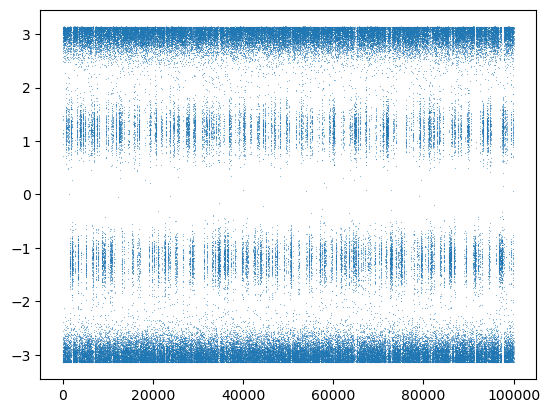

In [95]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
print(np.shape(ang))
print(ang)

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1,linewidth=0,marker='x',markersize=.1)
plt.plot(ang2,linewidth=0,marker='x',markersize=.1)
plt.clf()

plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle')
plt.ylabel('Counts')
plt.show()
#plt.scatter(ang1,marker='o',s=0.1)

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
print(CCCC_torsion)
print(np.rad2deg(CCCC_torsion))

plt.plot(CCCC_torsion,marker='x',markersize=.1,linewidth=0)
#plt.xlim([0,100])

(0.0, 10000.0)

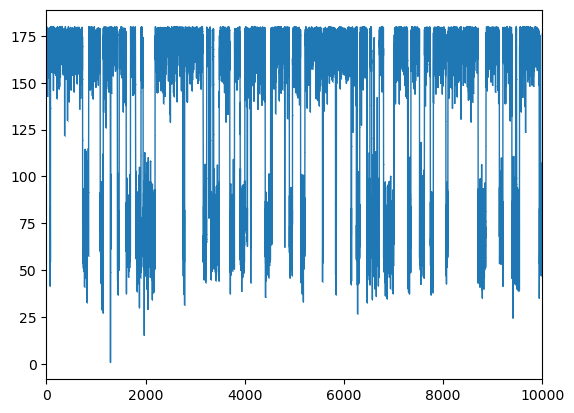

In [108]:
#print(np.where(CCCC_torsion<=0))
CCCC_tor_offset=np.rad2deg(CCCC_torsion)
#print(CCCC_tor_offset)
#for i in range(0,len(CCCC_tor_offset)):
#    if(CCCC_tor_offset[i]<0):
#        CCCC_tor_offset[i]+=360
        
plt.plot(np.abs(CCCC_tor_offset),marker='x',markersize=.1,linewidth=1)
plt.xlim([0,10000])

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [112]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####
#Let us define the higher free energy state as any value below 115

absdihedral=np.abs(CCCC_tor_offset)
highEdihedral=np.where(absdihedral<115)
phighE=np.size(highEdihedral)/np.size(absdihedral)
print("the probability of finding butane in the higher energy dihedral is: " + str(phighE))

#### Calculate Here #####
#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
#CCCC_dihe=CCCC_torsion[:,0]
#a=np.where(CCCC_dihe<0)
#print(a)
#print(CCCC_dihe[a])

#b=np.where(CCCC_dihe>-2)
#print(b)
#CCCC_dihe[b]
#c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
#print(c)

#Probability of being between 0 and -2 radians:
#print(len(CCCC_dihe[c])/len(CCCC_dihe))


the probability of finding butane in the higher energy dihedral is: 0.426


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.008885203251095961


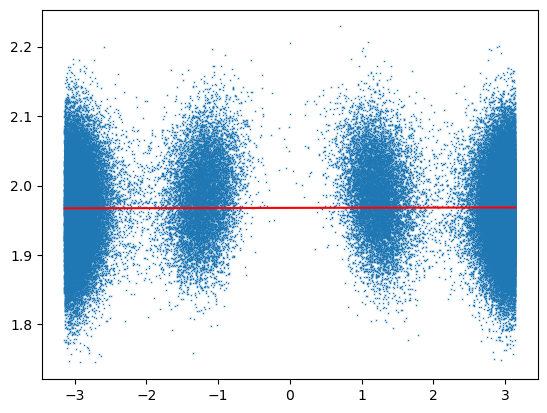

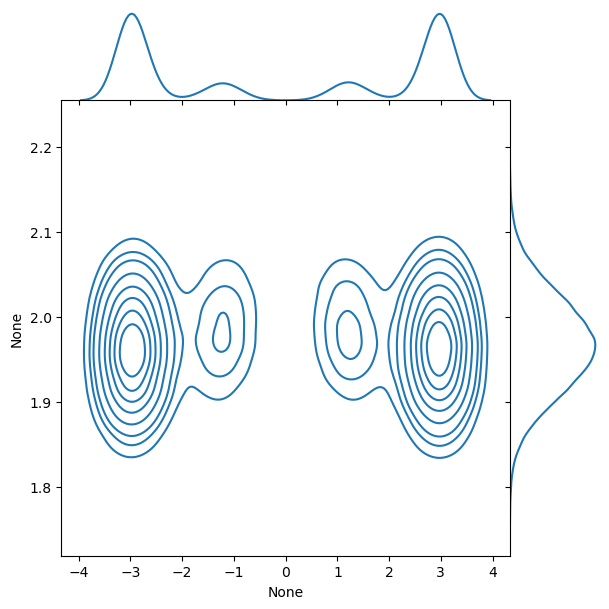

In [45]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?
CCCC_dihe

plt.scatter(CCCC_dihe,ang1,marker='x',s=0.1)
r=np.corrcoef(CCCC_dihe,ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_dihe,ang1,1)
line_fit
x=np.linspace(min(CCCC_dihe),max(CCCC_dihe),20)
y = line_fit[1]+x*line_fit[0]
plt.plot(x,y,c='r',label='best fit line')
plt.show()
##### ADD FANCY SEABORN PLOT HERE ######
sns.jointplot(x=CCCC_dihe,y=ang1,kind='kde',space=0,thresh=0)

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

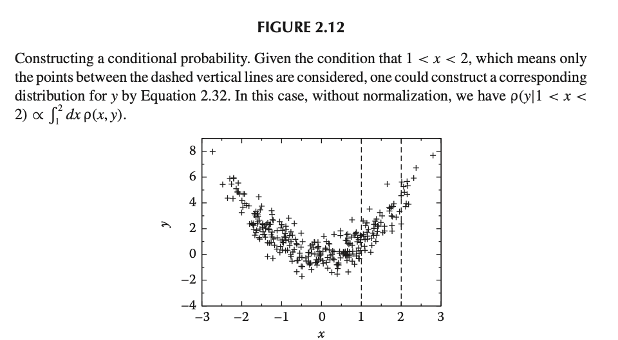

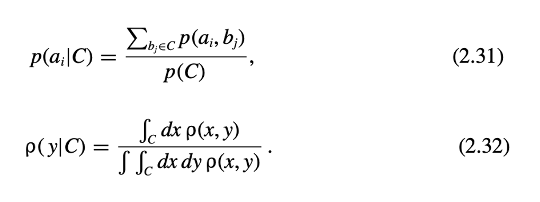

-40
-38
-36
-34
-32
[0.03791919 1.9609993  0.05820172]
-30
[0.03091526 1.96276226 0.0582811 ]
-28
[0.00954962 1.96758397 0.05785315]
-26
[-0.13819643  0.014244   -0.02517366]
-24
[5.47707811e-04 1.96906912e+00 5.78695465e-02]
-22
[3.26114981e-04 1.96447176e+00 5.24404609e-02]
-20
[4.37755627e-04 1.97652529e+00 5.89673793e-02]
-18
[1.27741462e-03 1.97355063e+00 5.59011176e-02]
-16
[0.0036173  1.9754711  0.05772203]
-14
[-0.09418377 -0.0906599  -0.18590938]
-12
[-0.09387343 -0.08711917 -0.22102247]
-10
[ 0.00331091  2.00010393 -0.05596114]
-8
[0.08886396 0.18365942 0.27286077]
-6
[1.68115987e-04 2.01578239e+00 5.64005830e-02]
-4
[0.01052361 0.18970895 0.38736913]
-2
[0.01849967 0.18328953 0.3550645 ]
0
[0.02212276 0.19214264 0.35749075]
2
[0.00580596 0.18975223 0.38791127]
4
[1.61454143e-04 2.03159278e+00 5.25606527e-02]
6
[-0.18281334  0.15323648  0.24310643]
8
[0.00283819 2.00164737 0.05658008]
10
[0.00633016 1.98929822 0.05496276]
12
[0.00653126 1.98066412 0.05671344]
14
[0.00337861 1

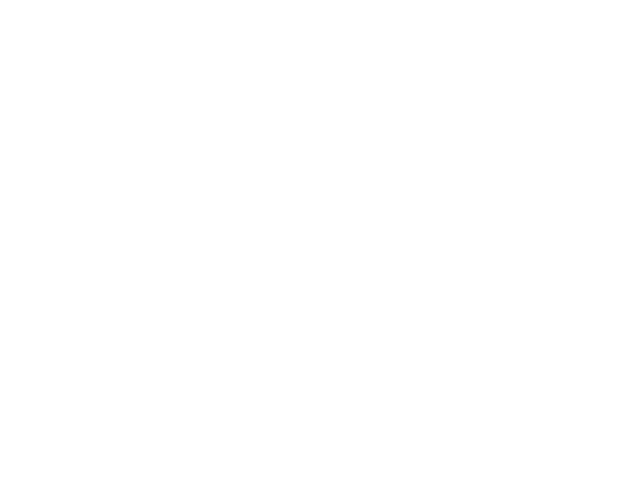

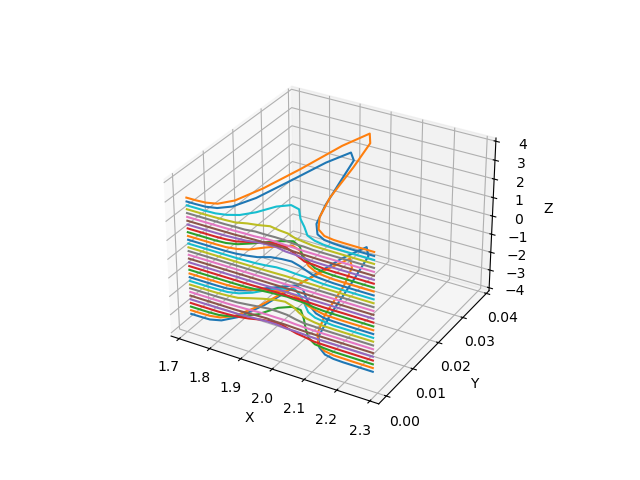

In [153]:
#Homework problem 3 Solution ##
#We will take slices of size 0.2 and then plot them in 3D
#Doing this for ang1

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

#Making the notebook interactive so that the graph is easier to visualize
%matplotlib widget

def histogram_3d(data, bins, num_range,total_points):
    counts, edges = np.histogram(data, bins=bins, range=num_range)
    centers = edges[:-1] + np.diff(edges)/2
    density = counts/total_points
    return centers,density 

fig = plt.figure()
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim([-4,4])

for i in range (-40, 40, 2):
    curr_indices=np.where((CCCC_dihe>(i/10.0)) & (CCCC_dihe<(i/10.0+0.2)))[0]
    ang1_in_range=ang1[curr_indices]
    if np.size(ang1_in_range) == 0:
        continue
    
    curr_ang1_centers,curr_ang1_densities=histogram_3d(ang1_in_range,20,[1.7,2.3],np.size(ang1))
    curr_ang1x,curr_ang1y=fit_gaussian(curr_ang1_centers,curr_ang1_densities)
    ax.plot(curr_ang1_centers,curr_ang1_densities,zs=i/10+0.1)

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
#CCCC_dihe
#a=np.where(CCCC_dihe<0)
#print(a)
#CCCC_dihe[a]
#b=np.where(CCCC_dihe>-2)
#print(b)
#CCCC_dihe[b]
#c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
#print(c)
#CCCC_dihe[c]

In [47]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.9515724 1.8890599 1.9106187 ... 1.9475055 1.9642272 1.9984161]
[1.8890599 1.9106187 1.9444959 ... 1.9475055 1.9642272 1.9984161]
[1.9515724 1.8890599 1.9106187 ... 1.8702377 1.9475055 1.9642272]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

In [155]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

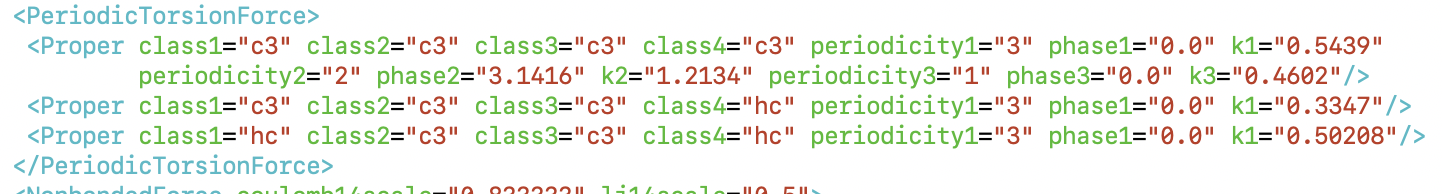

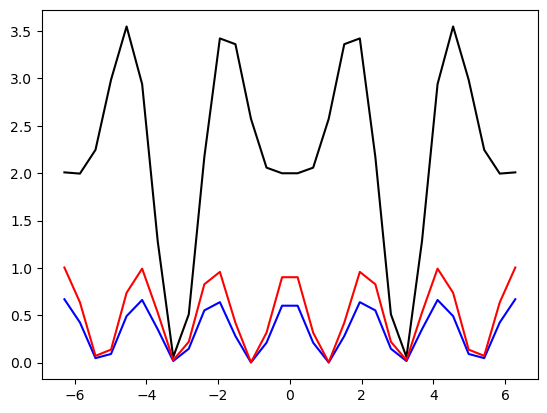

In [198]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms

#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(-2*math.pi,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e,color='k')
plt.plot(rad_ang,CCCH_e,color='b')
plt.plot(rad_ang,HCCH_e,color='r')

In [157]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

serial name element  resSeq resName  chainID segmentID
0        1   C1       C       1     NBU        0          
1        2  H11       H       1     NBU        0          
2        3  H12       H       1     NBU        0          
3        4  H13       H       1     NBU        0          
4        5   C2       C       1     NBU        0          
5        6  H21       H       1     NBU        0          
6        7  H22       H       1     NBU        0          
7        8   C3       C       1     NBU        0          
8        9  H31       H       1     NBU        0          
9       10  H32       H       1     NBU        0          
10      11   C4       C       1     NBU        0          
11      12  H41       H       1     NBU        0          
12      13  H42       H       1     NBU        0          
13      14  H43       H       1     NBU        0

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [158]:
#Lets Consider Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])


In [159]:
print(HCCH_indices)
print(HCCH_torsions)

[[8, 7, 4, 5], [8, 7, 4, 6], [9, 7, 4, 5], [9, 7, 4, 6], [6, 4, 0, 1], [6, 4, 0, 2], [6, 4, 0, 3], [5, 4, 0, 1], [5, 4, 0, 2], [5, 4, 0, 3], [13, 10, 7, 8], [12, 10, 7, 8], [11, 10, 7, 8], [13, 10, 7, 9], [12, 10, 7, 9], [11, 10, 7, 9]]
[[ 2.7490492  -1.558407    0.78091115 ...  0.9852341   3.0868452
  -1.2186934 ]
 [ 3.079423   -1.1920295   1.0937567  ...  0.813732    3.082257
  -1.1120576 ]
 [-2.8094747  -0.77990466  1.4864445  ...  1.261761   -3.0318482
  -0.8130329 ]
 ...
 [-2.9281504  -0.7832184   1.326739   ... -0.55976135  1.4605012
  -2.6961563 ]
 [ 2.9047322  -1.2880093   0.7250083  ... -1.7711743   0.45309892
   2.3779984 ]
 [ 2.9747212  -1.3737732   0.9429314  ... -1.3104432   0.71226394
   2.7538645 ]]


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

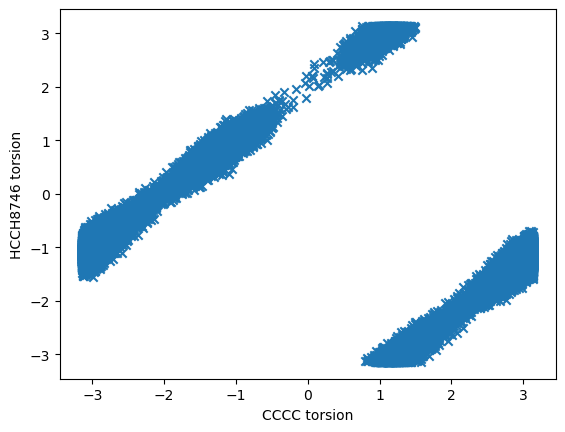

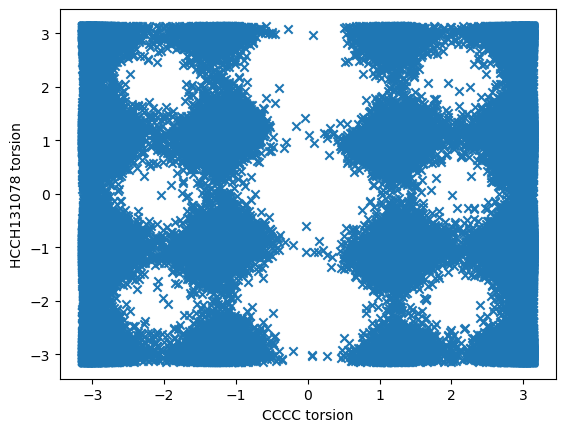

In [175]:
####WEEK 1 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Perhaps Consider CCCC vs. [8,7,4,5]
#Using inline since interactivity breaks the plot for some reason
%matplotlib inline

HCCH_8746=md.compute_dihedrals(traj, [[8,7,4,6]])
plt.scatter(CCCC_torsion,HCCH_8746,marker='x')
plt.xlabel("CCCC torsion")
plt.ylabel("HCCH8746 torsion")
plt.show()

#These two torsions are correlated as VSEPR dictates that the angle between substituents on the same carbon
#are held relatively constant. As H8 and C10 are attached to C7, while H6 and C0 are attached to C4, these
#are expected to be correlated as a result.

#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Perhaps Consider CCCC vs. [12,10,7,9]?

HCCH_131078=md.compute_dihedrals(traj, [[13,10,7,8]])
plt.scatter(CCCC_torsion,HCCH_131078,marker='x')
plt.xlabel("CCCC torsion")
plt.ylabel("HCCH131078 torsion")
plt.show()

#These are uncorrelated as the substituents on the carbons are not constrained together. For example, H13 may assume any
#position regardless of the position of C4. As such, the density plots simply follow the superimposition of two dihedrals

#For Example:
#plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',s=0.05)
#plt.show()
#plt.clf()


**Homework Problem #6: SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT**

The average offset is: 0.81033665


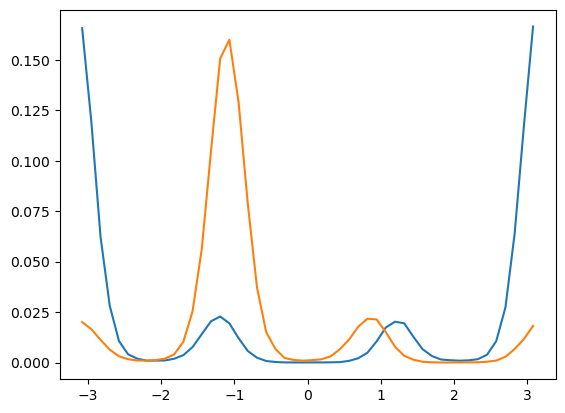

In [183]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT

Cdh_centers, Cdh_density = histogram_bincenters(CCCC_torsion, 50, [-np.pi,np.pi])
plt.plot(Cdh_centers, Cdh_density)

Hdh_centers, Hdh_density = histogram_bincenters(HCCH_8746, 50, [-np.pi,np.pi])
plt.plot(Hdh_centers, Hdh_density)

mean_offset=np.average(CCCC_torsion-HCCH_8746)
print("The average offset is: " + str(mean_offset))

#Like above, we expect this systematic offset as the molecular topology prefers to have the CCCC torsion be in the anti-
#conformer. Thus, some HCCH torsions (like the 8746 torsion) are expected to be offset.

***WEEK 2 Homework Problem #1: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

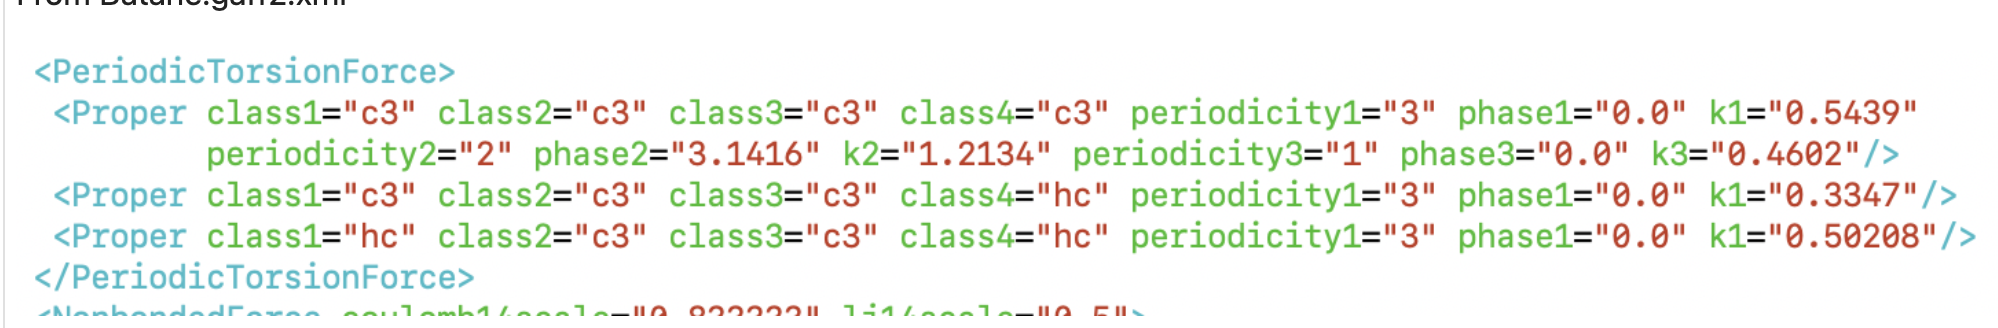

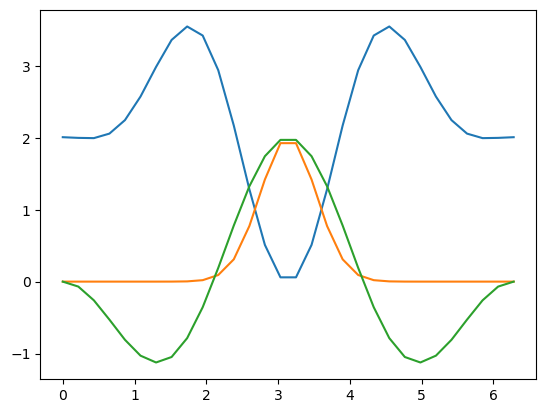

In [187]:
###SOLUTION#####

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

plt.plot(rad_ang,CCCC_e)

#We want to mimic a gaussian potential that adds potential energy when the CCCC diehdral = pi = 180 degrees
#We can think of this as approximating a guassian center at theta= 180
###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#Here is what we want our dihedral correction to look like:

gauss_cor = gauss(rad_ang, 2, np.pi, np.pi/8)
plt.plot(rad_ang,gauss_cor)

#Here I come up with a correction that should have the desired effect:

def TorsionCorrection(angle):
 e1=calc_torsion_energy(angle,-1,1,0)
 e2=calc_torsion_energy(angle,1,2,0)
 #e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2

torsion_cor=TorsionCorrection(rad_ang)

plt.plot(rad_ang,torsion_cor)

***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [205]:
#RUN NEW MD SIMULATION HERE#
forcefield_file_name = datadir+'butane2.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

os.path.join(workdir, "butane_sim2.xtc")

import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim2.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

/ipynb_files/CHEM96_06/Exercise_0/data/butane.pdb
/ipynb_files/CHEM96_06/Exercise_0/data/butane2.gaff2.xml
Minimizing...
Potential energy before minimization is 7.797528692807026 kJ/mol
Potential energy after minimization is 7.295271917828364 kJ/mol
Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,43.52308508683724,226.00437478390808
2000,45.52937991219349,253.06162104257163
Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,38.91552174950499,332.788922104856,--
500000,999.9999999901769,49.36678784038745,330.2100927602937,3.44e+03
750000,1499.9999999783536,43.03127970728387,217.7030541451649,3.53e+03
1000000,1999.9999999665301,40.40073871158315,346.81866368479666,3.59e+03
1250000,2499.9999999547067,37.320145050307815,328.86152927289925,3.57e+03
1500000,2999.9999999428833,53.81702378898318,449.97435323480335,3.55e+03
1750000,3499.99999993106,42.40249457984703,328.8436594659693,3.5

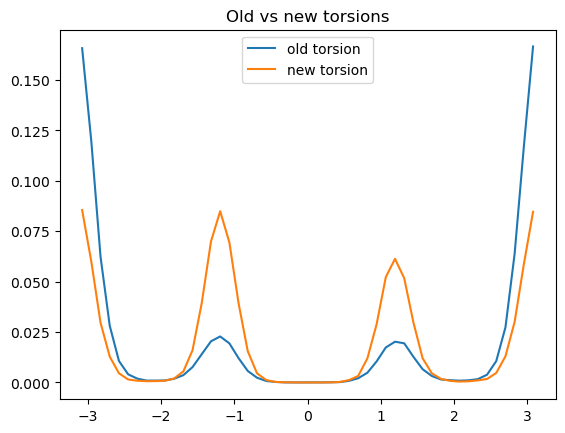

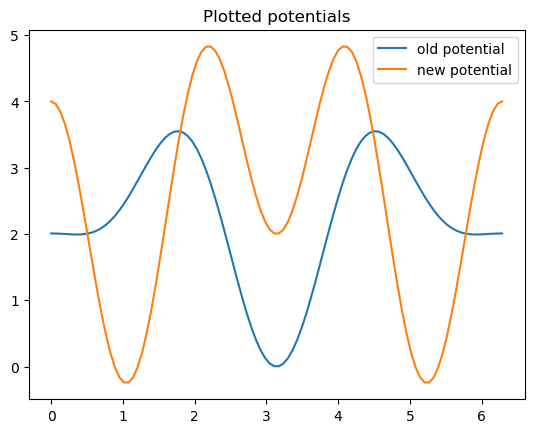

In [210]:
#Compare New Dihedral Distribution HERE)

traj_new = md.load(os.path.join(workdir, "butane_sim2.xtc"), top=PDB_file_name)
atoms, bonds = traj_new.topology.to_dataframe()
top=traj_new.topology

CCCC_new = md.compute_dihedrals(traj_new, [[0,4,7,10]])

Cdh_centers, Cdh_density = histogram_bincenters(CCCC_torsion, 50, [-np.pi,np.pi])
plt.plot(Cdh_centers, Cdh_density, label="old torsion")

Ndh_centers, Ndh_density = histogram_bincenters(CCCC_new, 50, [-np.pi,np.pi])
plt.plot(Ndh_centers, Ndh_density, label="new torsion")
plt.title("Old vs new torsions")
plt.legend()
plt.show()

#Here we plot the determined CCCC backbone potentials for the different force fields
#I'm not sure if this is what you meant by "determine coefficients", since back-calculating all torsion parameters
#from the distribution requires a system of roughly 15 equations (three parameters from each torsion term), 
#and that matrix will be a nightmare to construct and solve in O^3 time.
#Please let me know if I made a mistake in my assessment here, and if so I'd love to learn how to do it.

def CCCC_torsionE_param(angle,k1,k2,k3,p1,p2,p3):
 e1=calc_torsion_energy(angle,k1,3,p1)
 e2=calc_torsion_energy(angle,k2,2,p2)
 e3=calc_torsion_energy(angle,k3,1,p3)
 return e1+e2+e3

old_potential=np.linspace(0,2*np.pi,100)
old_potential_f=CCCC_torsionE_param(old_potential,0.5439,1.2134,0.4602,0,3.1416,0)

new_potential=np.linspace(0,2*np.pi,100)
new_potential_f=CCCC_torsionE_param(old_potential,2,-0.5,1,0,3.1416,3.1416)

plt.plot(old_potential, old_potential_f,label="old potential")
plt.plot(new_potential, new_potential_f,label="new potential")
plt.title("Plotted potentials")
plt.legend()
plt.show()

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


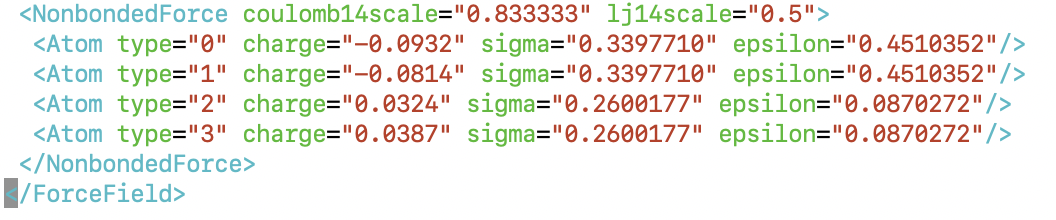




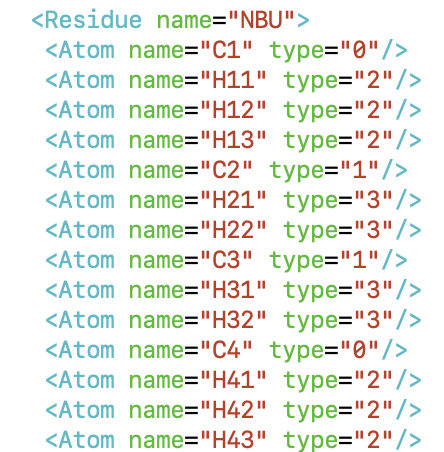

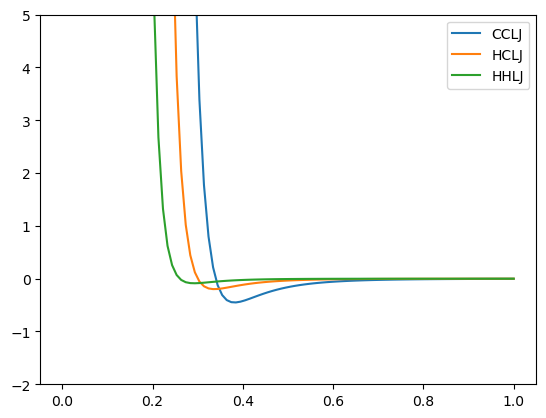

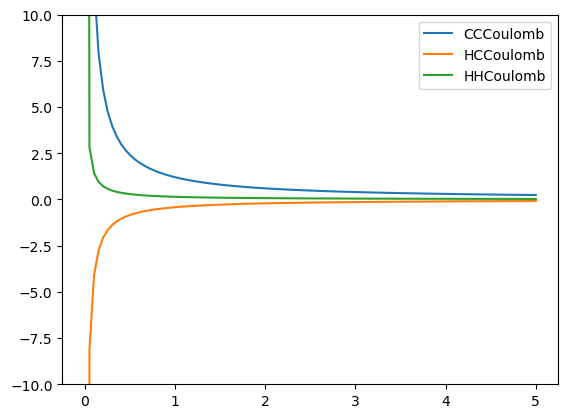

In [224]:
#Plot LJ and Couloumb Potentionals Here.
#For LJ, OpenMM uses the Lorentz-Berthelot rule, where sigmas are averaged arithmatically and epsilons geometrically.
#Not plotting cutoffs or considering 1,4 factors, as that would require a tedious, system-specific amount of graphs
#Not using reduced units
#The electric conversion factor is used as-provided by the GROMACS documentation; OpenMM and GROMACS use the same basic units
#Thus, 1/4pie0=138.935458kJ mol−1nm e−2

def calculateLJ(dist,s1,s2,e1,e2):
    avgs=(s1+s2)/2
    avge=np.sqrt(e1*e2)
    
    LJ=4*avge*((avgs/dist)**12-(avgs/dist)**6)
    return LJ

def calculateCoulomb(dist,c1,c2):
    coulomb=138.935458*c1*c2/dist
    return coulomb

#plotting,
#Since there are slightly different values for charge and the differences are small between different types of C/H
#I'll represent carbon arbitrarily with type 0, and hydrogen with type 2
CCLJx=np.linspace(0.001,1,100)
CCLJy=calculateLJ(CCLJx,0.3397710,0.3397710,0.4510352,0.4510352)

HCLJx=np.linspace(0.001,1,100)
HCLJy=calculateLJ(HCLJx,0.3397710,0.2600177,0.4510352,0.0870272)

HHLJx=np.linspace(0.001,1,100)
HHLJy=calculateLJ(HCLJx,0.2600177,0.2600177,0.0870272,0.0870272)

plt.plot(CCLJx,CCLJy,label="CCLJ")
plt.plot(HCLJx,HCLJy,label="HCLJ")
plt.plot(HHLJx,HHLJy,label="HHLJ")
plt.ylim(-2,5)
plt.legend()
plt.show()

CCCoulombx=np.linspace(0.001,5,100)
CCCoulomby=calculateCoulomb(CCCoulombx,-0.0932,-0.0932)

HCCoulombx=np.linspace(0.001,5,100)
HCCoulomby=calculateCoulomb(HCCoulombx,-0.0932,0.0324)

HHCoulombx=np.linspace(0.001,5,100)
HHCoulomby=calculateCoulomb(HHCoulombx,0.0324,0.0324)

plt.plot(CCCoulombx,CCCoulomby,label="CCCoulomb")
plt.plot(HCCoulombx,HCCoulomby,label="HCCoulomb")
plt.plot(HHCoulombx,HHCoulomby,label="HHCoulomb")
plt.ylim(-10,10)
plt.legend()
plt.show()